In [129]:

# Importando as bibliotecas gerais:
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.special import expit
import tensorflow.compat.v1 as tf

# Importando as bibliotecas Scikit Learn:
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Importando as métricas:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [137]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [138]:
# Define the number of examples.
N = 1000

# Criando o dataset.
X, y = make_moons(N, noise=0.1, random_state=42)

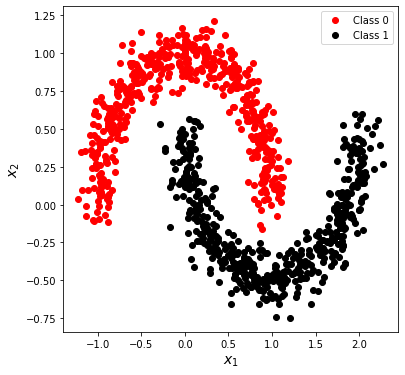

In [139]:
# Definindo os índices
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

# Plotando a figura:
fig = plt.figure(figsize=(6,6))
plt.plot(X[idx0,0], X[idx0,1], 'ro', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'ko', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend()
plt.show()

In [140]:
y_vector = y.reshape(-1, 1)

# Separando em conjunto de treinamento e teste:
x_train, x_test, y_train, y_test = train_test_split(X, y_vector, test_size=0.20, random_state=42)

In [141]:
# Definindo a função hipótese:
x_train_h = np.c_[np.ones((len(y_train), 1)), x_train, x_train**2, x_train**3]
x_test_h = np.c_[np.ones((len(y_test), 1)), x_test, x_test**2, x_test**3]

In [142]:
# Índice randômico
def select_random_batch(X, y):
    random_index = np.random.randint(N)
    X_i = X[random_index:random_index+1]
    y_i = y[random_index:random_index+1]
    return X_i, y_i

# Função para resetar o grafo:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [143]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs2"
logdir = "{}/run-{}/".format(root_logdir, now)

# Number of Features
input_number = 6

# Place holder for training data X
X = tf.placeholder(tf.float32, shape =(None, input_number + 1), name = "X" ) 

# Place holder for training label data y
y = tf.placeholder(tf.float32, shape =(None, 1), name = "y" ) 

# Initialize the Random value for theta
theta = tf.Variable(tf.random_uniform([input_number + 1, 1], -1.0, 1.0, seed=42), name="theta") #Initialize the Random value for theta
y_pred = tf.matmul(X, theta, name="predictions")

# Tensorflow Operations
logits = tf.matmul(X, theta, name="logits") 

# Calculate the probability
y_proba = tf.sigmoid(logits) 

# Loss function
loss = tf.losses.log_loss(y, y_proba) 

learning_rate = 0.02
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

epochs = 2000

train_summary = tf.summary.scalar('Training', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        for idx in range(N):
            X_i, y_i = select_random_batch(x_train_h, y_train)
            sess.run(training_op, feed_dict={X: X_i, y: y_i})
            loss_val = loss.eval({X: x_test_h, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            y_proba_val = y_proba.eval(feed_dict={X: x_test_h, y: y_test})
                                    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")                           

file_writer.close()

Epoch: 0 	Loss: 0.2965591
Epoch: 100 	Loss: 0.030251717
Epoch: 200 	Loss: 0.020007202
Epoch: 300 	Loss: 0.01567998
Epoch: 400 	Loss: 0.012979445
Epoch: 500 	Loss: 0.012040797
Epoch: 600 	Loss: 0.011432376
Epoch: 700 	Loss: 0.009871555
Epoch: 800 	Loss: 0.009386369
Epoch: 900 	Loss: 0.008242791
Epoch: 1000 	Loss: 0.008219175
Epoch: 1100 	Loss: 0.007583324
Epoch: 1200 	Loss: 0.0069234436
Epoch: 1300 	Loss: 0.0069544967
Epoch: 1400 	Loss: 0.006456003
Epoch: 1500 	Loss: 0.00641597
Epoch: 1600 	Loss: 0.0062169717
Epoch: 1700 	Loss: 0.0061327587
Epoch: 1800 	Loss: 0.0056780847
Epoch: 1900 	Loss: 0.0055845203


In [144]:
# Checkpoint
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()
    
np.allclose(best_theta, best_theta_restored)

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


True

In [145]:
# Predição:
y_pred = (y_proba_val >= 0.5)
prec = precision_score(y_test, y_pred)

In [146]:
# Imprime a precisão:
print('Precisão alcançada de: {:.2f}%'.format(prec * 100))

Precisão alcançada de: 100.00%


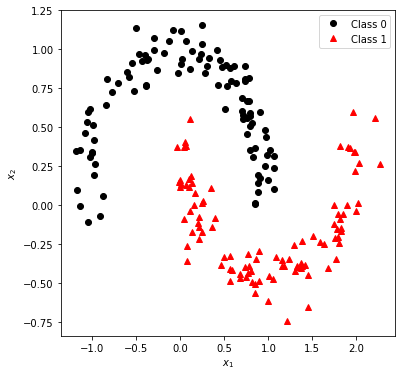

In [147]:
# Reshape
y_pred_idx = y_pred.reshape(-1) 

# Definição dos índices
idx0 = np.argwhere(y_pred_idx == 0)
idx1 = np.argwhere(y_pred_idx == 1)

# Plotagem:
fig = plt.figure(figsize=(6,6))
plt.plot(x_test[idx0,0], x_test[idx0,1], 'ko', label='Class 0')
plt.plot(x_test[idx1,0], x_test[idx1,1], 'r^', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()